### Death toll data from Wikipedia

This is an attempt to summarise war death toll data from Wikipedia: https://en.wikipedia.org/wiki/List_of_wars_by_death_toll

I downloaded the data in late 2023 and since then the data has changed a bit so and update is required. A similar topic has been recently explored in https://ourworldindata.org/war-and-peace, but their data starts at 1800. I'm not sure how Wikipedia data compares to other sources in terms of accuracy. My goal was to replicate and extend this graph https://en.wikipedia.org/wiki/List_of_anthropogenic_disasters_by_death_toll#/media/File:Wars_by_Death_Toll_Chart.jpg

The general approach is to extract and clean the dates and death ranges.

In [1]:
import pandas as pd
w = pd.read_csv('warsTollWiki.csv', skiprows=2)
w.head()

,War,Death\nrange,Date,Combatants,Location,Notes
0,Conquests of Cyrus the Great,"100,000+",549 BC–530 BC,Persian Empire vs. various states,Middle East,Number given is the sum of all deaths in battl...
1,Greco–Persian Wars,"300,000+",499 BC–449 BC,Greek City-States vs. Persian Empire,Greece,NaN
2,Chinese Warring States,"1,500,000+",c. 475 BC – 221 BC,Seven great powers of China,China,"Estimated at 1,500,000 before Qin's wars of un..."
3,Samnite Wars,"33,500+",343 BC–290 BC,Roman Republic vs. Samnites,Italy,Number given is the sum of all deaths in battl...
4,Wars of Alexander the Great,"142,000+",336 BC–323 BC,Macedonian Empire and other Greek City-States ...,Middle East / North Africa / Central Asia / India,Number given is the sum of all deaths in battl...


In [2]:
w[w['War'] == 'World War I']


,War,Death\nrange,Date,Combatants,Location,Notes
111,World War I,"17,000,000 (excluding the Spanish flu)",1914–1918,Allied Powers vs. Central Powers,Worldwide,[27] – Also known as the Great War


In [3]:
'''
This function takes the middle year of a range as the year to display on graph


#find start date
#if BC
import math
import re

def cleanDate(rawDate):
    try:
        if "–" not in rawDate:
            return int(rawDate)
        else:
            #extract
            year1, year2 = re.findall(r'\d+', rawDate)
            year1 = int(year1)
            year2 = int(year2)
            if "BC" in rawDate:
                return (year1+year2)//2
            else:
                return math.ceil((year1+year2)/2)
    except ValueError:
        return rawDate
'''
#use start date as reference point, not the middle date

import re

def extractFirstNumber(stringWithNumbers):
    try:
        # Find the first group of digits, including commas
        match = re.search(r'[\d,]+', stringWithNumbers)
        
        if match:
            # Replace commas and convert to an integer
            return int(match.group().replace(',', ''))
        else:
            return stringWithNumbers
    except ValueError:
        return stringWithNumbers


    
#calculate average toll if there is a range ?


#graph by location

In [4]:
w['cleanDate'] = w['Date'].map(extractFirstNumber)


In [5]:
#check whether all dates got extracted

# This approach directly filters rows where the conversion to numeric results in NaN, 
# indicating that those rows contain string values in the 'cleanDate' column.

rows_with_strings = w[pd.to_numeric(w['cleanDate'], errors='coerce').isna()]
rows_with_strings

,War,Death\nrange,Date,Combatants,Location,Notes,cleanDate


In [6]:
#create a BC column
w['BC'] = w['Date'].str.contains('BC')

In [7]:
w = w.rename(columns = {'Death\nrange':'casualties'})


Extract higher death toll range and lower death toll range and put them in separate columns

In [8]:
w['lowerRange'] = w['casualties'].map(extractFirstNumber)

In [9]:
#extract higher range or any number if there is just one number
import re

def extractSecondOrFirstNumber(stringWithNumbers):
    
    try:
        # Remove commas, then find all groups of digits
        stringWithNumbers =stringWithNumbers.replace(',', '')
        matches = re.findall(r'\d+',stringWithNumbers)
        if matches:
            if len(matches) == 1:
                return int(matches[0])
            elif len(matches) == 2 and '[' in stringWithNumbers and ']' in stringWithNumbers:
                # Check if the second value is in brackets
                return int(matches[0])
            else:
                return int(matches[1])
        else:
            return stringWithNumbers
    except ValueError:
        return stringWithNumbers
    

In [10]:
w['higherRange'] = w['casualties'].map(extractSecondOrFirstNumber)

In [11]:
df = w[['War','cleanDate', 'BC', 'lowerRange', 'higherRange']]

In [12]:
df.describe()

,cleanDate,lowerRange,higherRange
count,201.000000,2.010000e+02,2.010000e+02
mean,1637.781095,1.960779e+06,2.917866e+06
std,556.089509,7.183776e+06,9.359959e+06
min,58.000000,1.500000e+04,2.500000e+04
25%,1616.000000,1.000000e+05,1.100000e+05
50%,1894.000000,2.500000e+05,3.620000e+05
75%,1971.000000,7.700000e+05,1.200000e+06
max,2023.000000,8.000000e+07,8.000000e+07


In [13]:
#find row with max value
max_lower_range_row = df.loc[df['lowerRange'].idxmax()]

print(max_lower_range_row)

War            World War II
cleanDate              1939
BC                    False
lowerRange         80000000
higherRange        80000000
Name: 123, dtype: object


In [14]:
df[df['higherRange'] > 30000000]

,War,cleanDate,BC,lowerRange,higherRange
18,Three Kingdoms War,184,False,36000000,40000000
25,An Lushan Rebellion,755,False,13000000,36000000
30,Mongol invasions and conquests,1206,False,30000000,40000000
84,Taiping Rebellion,1850,False,20000000,70000000
123,World War II,1939,False,80000000,80000000


In [15]:
df[df.War == 'Reconquista']

,War,cleanDate,BC,lowerRange,higherRange
23,Reconquista,711,False,7000000,7000000


### Deat toll graph - first attempt

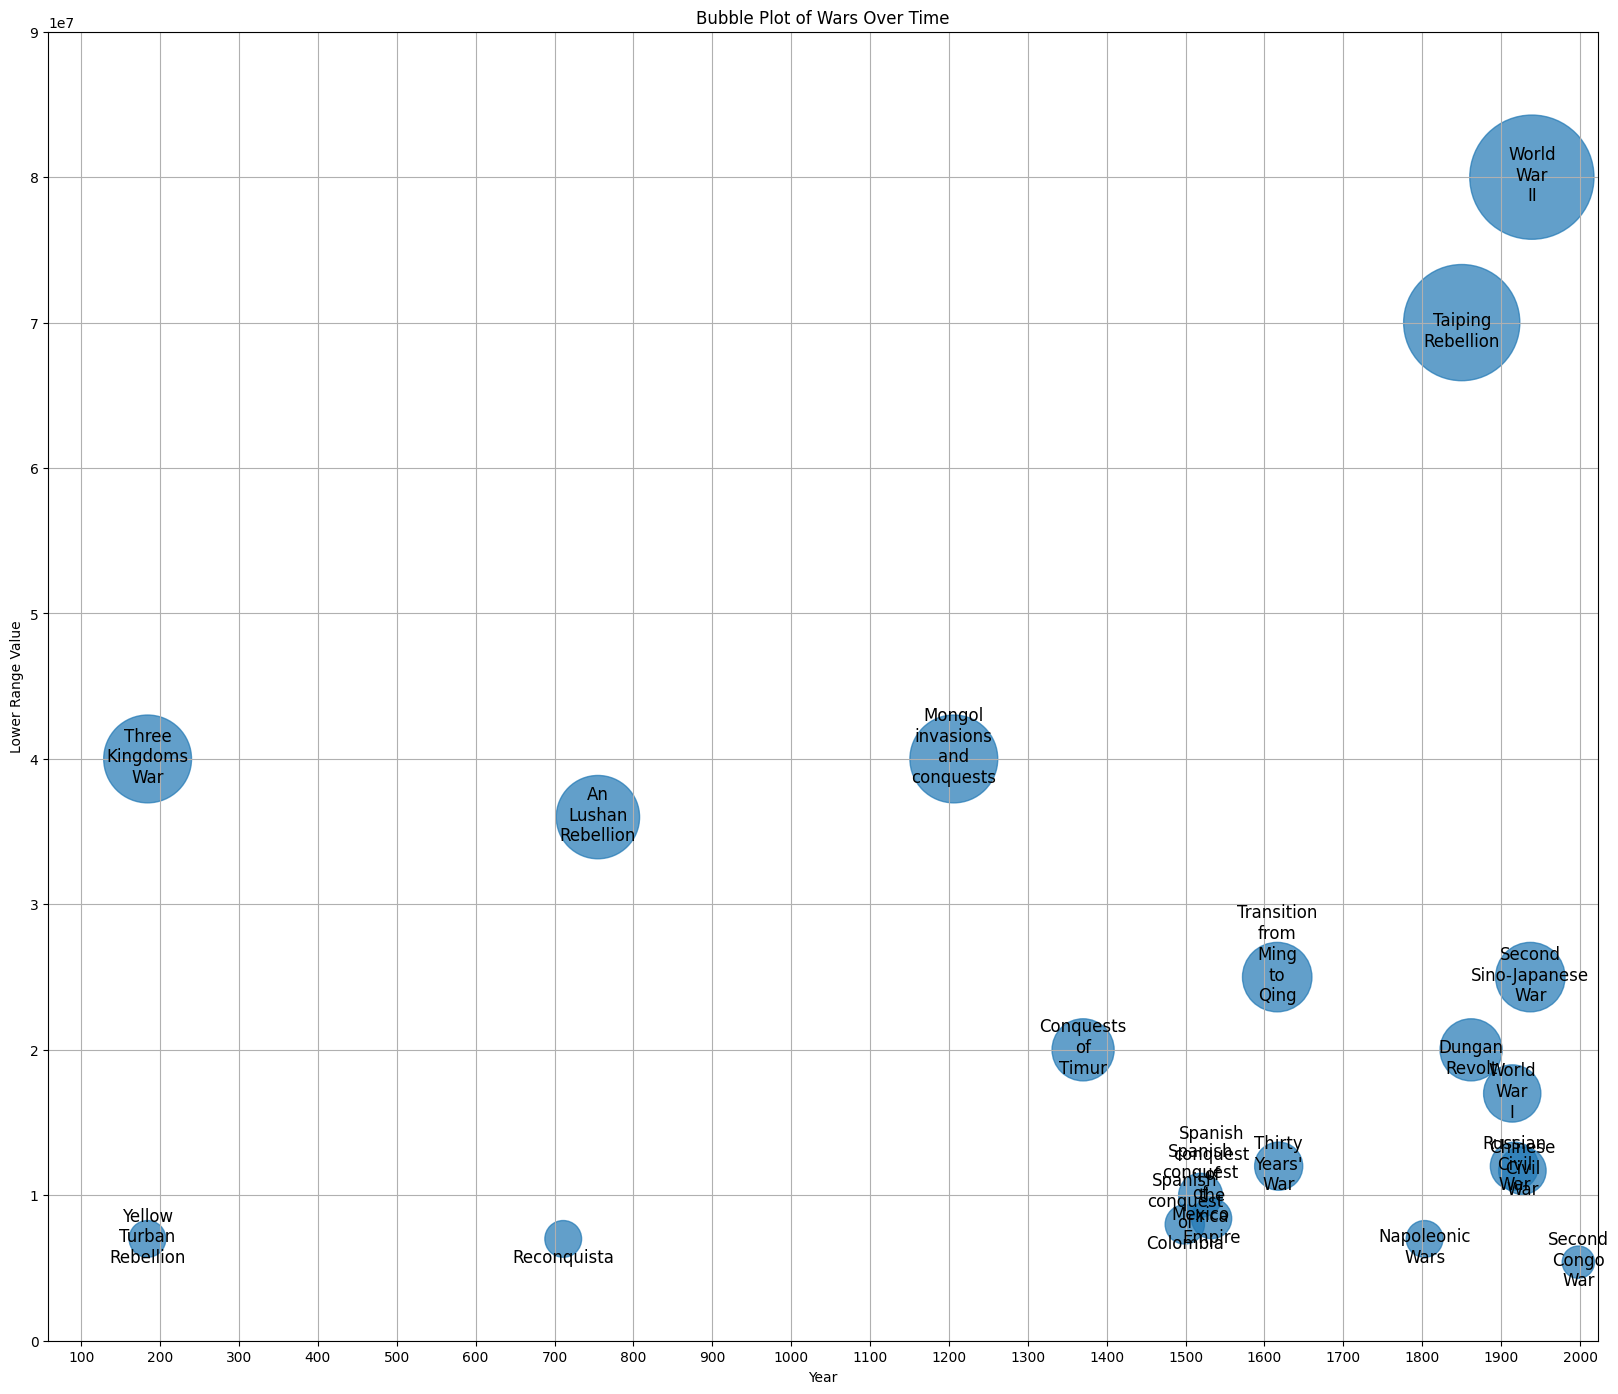

In [16]:
'''
The issue with this bubble graph is the overlapping bubbles and text. I tried using jitter but that didn't help too much.
The text is split into lines to fit better.

'''

import matplotlib.pyplot as plt
import numpy as np

# Assuming your DataFrame is named 'df'
plt.figure(figsize=(20, 17))

# Filter data for BC and AD separately
ad_data = df[(df['BC'] == False) & (df['higherRange'] > 5000000)]




jitter = 0.1  # Adjust the jitter value based on your preference
# plt.scatter(x_values + np.random.normal(0, jitter, size=len(x_values)),
#             y_values + np.random.normal(0, jitter, size=len(y_values)),
#             s=bubble_size, alpha=0.7)

# Plot AD data
scatter = plt.scatter(ad_data['cleanDate']+ np.random.normal(0, jitter, size=len(ad_data['cleanDate'])), ad_data['higherRange']+np.random.normal(0, jitter, size=len(ad_data['higherRange'])), s=ad_data['higherRange'] / 10000, alpha=0.7)


# Set custom limits for better visibility
plt.xlim(min(df['cleanDate']), max(df['cleanDate']))
plt.ylim(0, max(df['higherRange']) + 10000000)  # Adjusted upper limit up to 9M

# Add ticks every 50 years starting from 0 to 2100
plt.xticks(range(100, 2100, 100))

# Add 'war' field as multiline text on each bubble
# for x, y, war in zip(ad_data['cleanDate'], ad_data['higherRange'], ad_data['War']):
#     plt.annotate(war, (x, y), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=12, color='black')
    
    
for x, y, war in zip(ad_data['cleanDate'], ad_data['higherRange'], ad_data['War']):
    if len(war)>1:
        lines = war.split()
        text = '\n'.join(lines)
    else:
        text = war
    plt.annotate(text, (x, y), textcoords="offset points", xytext=(0, -17), ha='center', fontsize=12, color='black')

    
    

# Customize the plot
plt.title('Bubble Plot of Wars Over Time')
plt.xlabel('Year')
plt.ylabel('Lower Range Value')
#plt.legend()
plt.grid(True)

# Improve layout
# plt.tight_layout()

plt.show()

When I compare my graph to the original one I see scope for improvment. My y scale is not clear, the bubbles overlap.The original graph has done some scale modifications so that the bubbles fit nicely, the distances on y axis are not proportional. It's a bit odd that the distance between 10M and 20M is so wide. I would widen more the one between 20M and 30M to make the bubbles clearer.

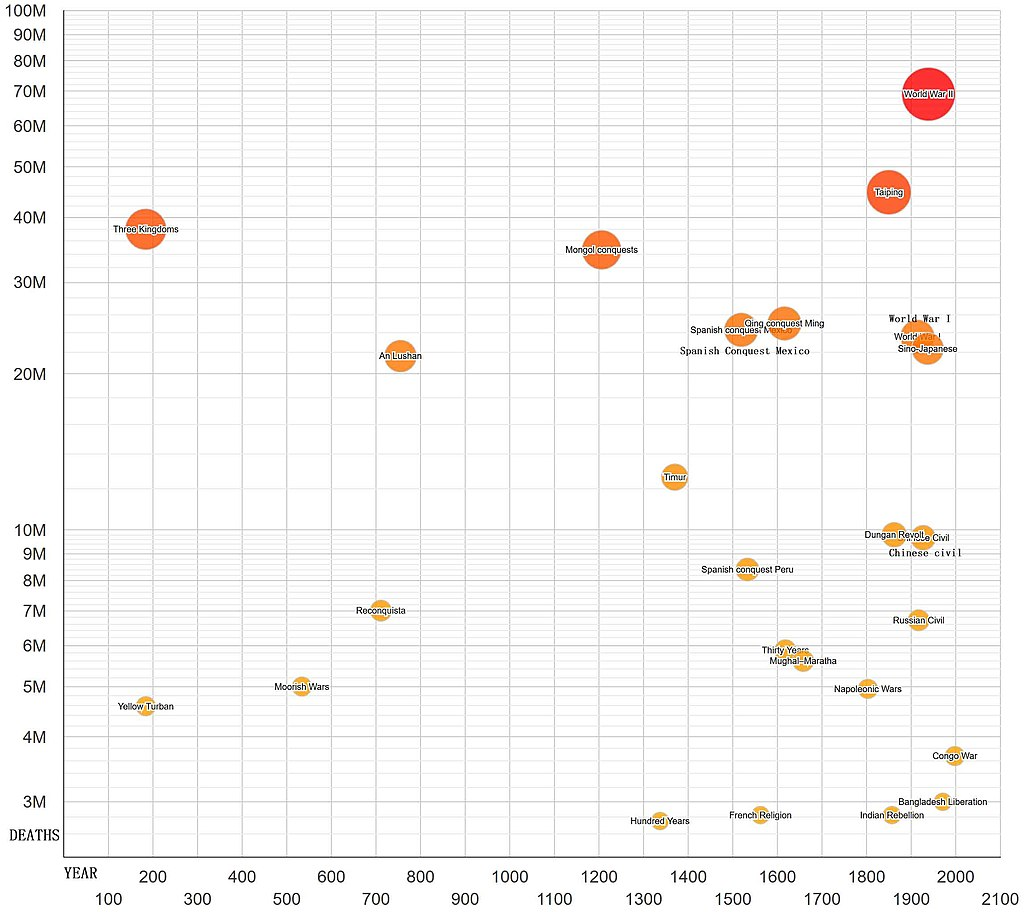


OK, so I want to make the distances on the y axis more even for visibility, but ideally I want to preserve the magnitude of the spaces at least to some extent. I want to avoid what happens in the original graph where the space between 10M and 20M is bigger than between 20M and 30M, even though there are fewer data points.

My approach will be the following:
1. Identify cases where data points (higher range) are close and round to 1 or 2 decimals (we don't want v. close data points showing on separate lines)
2. Calculate distances between ordered higher range values
3. Assign values to similar ranks - group ranks
4. Create a new column with data points for tics, it will not correspond to the actual values of higherRange but rather it will reflect the distances between the values

In [17]:
#look only at AD data with over 1M deaths

ad_data = df[(df['BC'] == False) & (df['higherRange'] > 1000000)]


In [18]:
#round higherRange so v. similar values are treated as same and will be displayed on one tick line 
def decimal2rounder(x, pos):
    return round(x / 1e6, 2)
#adjusted_combined_df['sum_higher_rank_in_M'] = 
#adjusted_combined_df['sum_higher_rank_in_M'] = adjusted_combined_df['sum_higher_rank'].apply(lambda x: millions_formatter_int(x, 0))
#ad_data['higher_range_2decimal'] = ad_data['higherRange'].map(lambda x: decimal2rounder(x, 0))
ad_data.loc[:, 'higher_range_2decimal'] = ad_data['higherRange'].map(lambda x: decimal2rounder(x, 0))

#rerun the cumulative

C:\Users\karol\AppData\Local\Temp\ipykernel_69352\3735933282.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ad_data.loc[:, 'higher_range_2decimal'] = ad_data['higherRange'].map(lambda x: decimal2rounder(x, 0))


In [19]:
ad_data

,War,cleanDate,BC,lowerRange,higherRange,higher_range_2decimal
14,Jewish–Roman Wars,66,False,1270000,2000000,2.00
15,First Jewish–Roman War,66,False,250000,1100000,1.10
18,Three Kingdoms War,184,False,36000000,40000000,40.00
19,Yellow Turban Rebellion,184,False,3000000,7000000,7.00
22,Arab–Byzantine Wars,629,False,2000000,2000000,2.00
23,Reconquista,711,False,7000000,7000000,7.00
25,An Lushan Rebellion,755,False,13000000,36000000,36.00
28,Crusades,1095,False,1000000,3000000,3.00
30,Mongol invasions and conquests,1206,False,30000000,40000000,40.00
32,Hundred Years' War,1337,False,2300000,3500000,3.50


In [20]:

#rank
#calculate distances between values in an array
import numpy as np
sorted_y = np.sort(ad_data['higher_range_2decimal'])
sorted_y
from scipy.stats import rankdata
ranks = rankdata(np.diff(sorted_y))
ranks
ranks_adjusted = ranks / 10
ranks_adjusted

# #set first rank to 1 to avoid difference in leangth problem
ranks_adjusted = np.insert(ranks_adjusted, 0, 1)-1 #NOTE: for same values the rank must be 0
rankDf = pd.DataFrame({'higher_range_2decimal': sorted_y, 'rank': ranks_adjusted})
rankDf

#NOTE: for same values the rank must be 0

,higher_range_2decimal,rank
0,1.10,0.00
1,1.10,0.00
2,1.20,1.50
3,1.20,0.00
4,1.25,1.20
5,1.26,1.00
6,1.40,1.70
7,1.46,1.30
8,1.50,1.10
9,1.50,0.00


In [21]:
# Create a new column for the cumulative sum
rankDf['sum_higher_rank'] = rankDf['higher_range_2decimal'].copy()
for i in range(1, len(rankDf)):
    rankDf.loc[i, 'sum_higher_rank'] = rankDf.loc[i - 1, 'sum_higher_rank'] + (rankDf.loc[i, 'rank'])

rankDf

,higher_range_2decimal,rank,sum_higher_rank
0,1.10,0.00,1.10
1,1.10,0.00,1.10
2,1.20,1.50,2.60
3,1.20,0.00,2.60
4,1.25,1.20,3.80
5,1.26,1.00,4.80
6,1.40,1.70,6.50
7,1.46,1.30,7.80
8,1.50,1.10,8.90
9,1.50,0.00,8.90


In [22]:
# Remove duplicates from one of the DataFrames based on the key column
#I cant just merge based on higher range because it creates duplicates
#I need to sort my main df and just attach it to the sorted ranks df
#YOU HAVE TO RESET INDEX HERE OR THE CONCAT WONT WORK NICELY
sorted_ad_data = ad_data.sort_values(by='higher_range_2decimal', ascending=True)
sorted_ad_data.reset_index(drop=True, inplace=True)
# Concatenate df2 to the right of df1 along the columns axis (horizontally)
rankDf.reset_index(drop=True, inplace=True)

# Concatenate rankDf columns to the right of sorted_ad_data along the columns axis (horizontally)
combined_df = pd.concat([sorted_ad_data, rankDf], axis=1)
combined_df = combined_df.loc[:, ~combined_df.columns.duplicated()]




combined_df

,War,cleanDate,BC,lowerRange,higherRange,higher_range_2decimal,rank,sum_higher_rank
0,First Jewish–Roman War,66,False,250000,1100000,1.10,0.00,1.10
1,French conquest of Algeria,1830,False,595665,1095665,1.10,0.00,1.10
2,Spanish American wars of independence,1808,False,600000,1200000,1.20,1.50,2.60
3,Paraguayan War,1864,False,300000,1200000,1.20,0.00,2.60
4,War of the Spanish Succession,1701,False,400000,1250000,1.25,1.20,3.80
5,War on terror,2001,False,272000,1260000,1.26,1.00,4.80
6,Seven Years' War,1756,False,868000,1400000,1.40,1.70,6.50
7,Spanish conquest of Yucatán,1519,False,1460000,1460000,1.46,1.30,7.80
8,Algerian War,1954,False,400000,1500000,1.50,1.10,8.90
9,Iran–Iraq War,1980,False,500000,1500000,1.50,0.00,8.90


In [23]:
#these will overlap each other so we need to add manual labels
combined_df[combined_df['higherRange'] == 2000000]

,War,cleanDate,BC,lowerRange,higherRange,higher_range_2decimal,rank,sum_higher_rank
11,Jewish–Roman Wars,66,False,1270000,2000000,2.0,2.65,11.55
12,Partition of India,1946,False,200000,2000000,2.0,0.00,11.55
13,Soviet–Afghan War,1979,False,600000,2000000,2.0,0.00,11.55
14,Tây Sơn rebellion,1771,False,1200000,2000000,2.0,0.00,11.55
15,Arab–Byzantine Wars,629,False,2000000,2000000,2.0,0.00,11.55
16,Mfecane,1810,False,1000000,2000000,2.0,0.00,11.55
17,Second Sudanese Civil War,1983,False,1000000,2000000,2.0,0.00,11.55


In [24]:
#these will overlap each other so we need to add manual labels
combined_df[combined_df['higherRange'] == 1500000]

,War,cleanDate,BC,lowerRange,higherRange,higher_range_2decimal,rank,sum_higher_rank
8,Algerian War,1954,False,400000,1500000,1.5,1.1,8.9
9,Iran–Iraq War,1980,False,500000,1500000,1.5,0.0,8.9
10,Ethiopian Civil War,1974,False,500000,1500000,1.5,0.0,8.9


In [25]:
#these will overlap each other so we need to add manual labels
combined_df[combined_df['higherRange'] == 1200000]

,War,cleanDate,BC,lowerRange,higherRange,higher_range_2decimal,rank,sum_higher_rank
2,Spanish American wars of independence,1808,False,600000,1200000,1.2,1.5,2.6
3,Paraguayan War,1864,False,300000,1200000,1.2,0.0,2.6


C:\Users\karol\AppData\Local\Temp\ipykernel_69352\2953218388.py:44: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  ax.annotate(war, (x, y), textcoords=offset_transform, ha='center', fontsize=8, color='black')


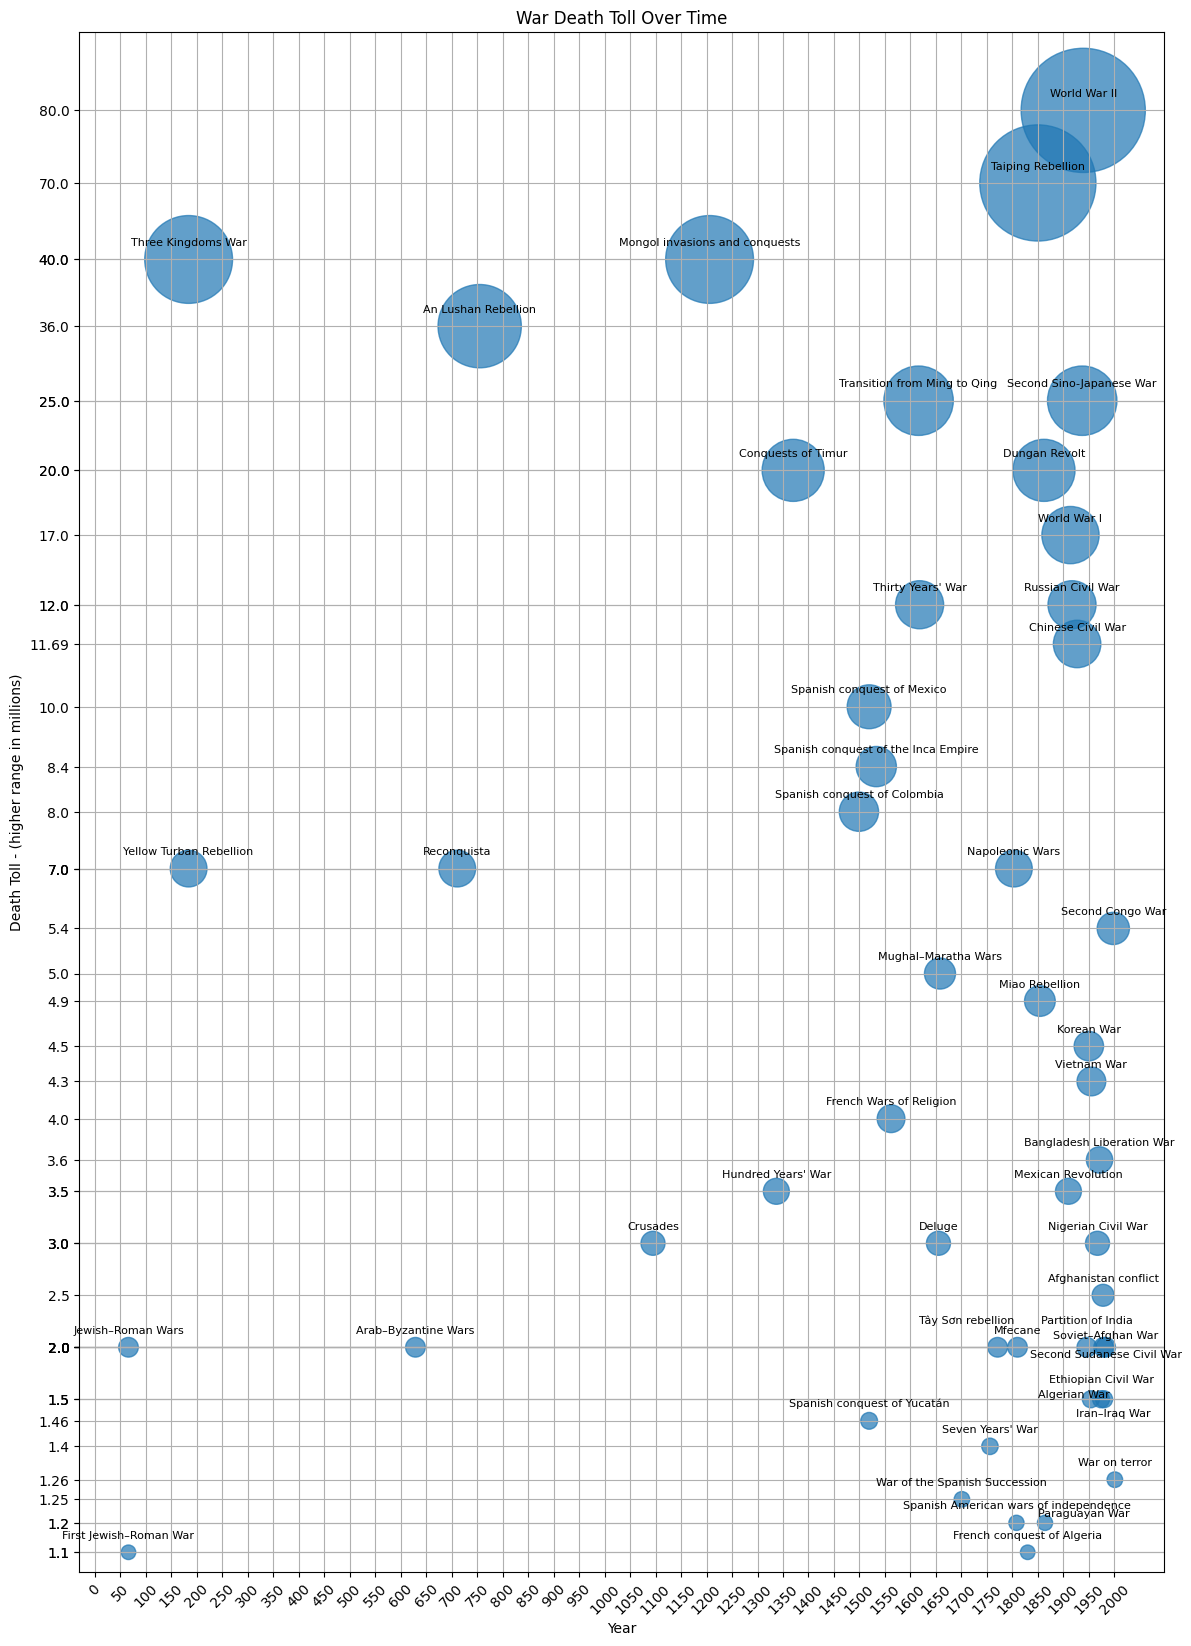

In [26]:
from matplotlib.transforms import offset_copy

import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(14, 20))


# Create a copy of the transform with an offset for annotations
offset_transform = offset_copy(ax.transData, fig=ax.figure, x=0, y=10, units='points')

# Scatter plot with bubble sizes based on 'higherRange'
ax.scatter(combined_df['cleanDate'], combined_df['sum_higher_rank'], s=[size / 10000 for size in combined_df['higherRange']], alpha=0.7)

    
# # Annotate each point with the respective 'War' label using offset_transform
# for x, y, war in zip(combined_df['cleanDate'], combined_df['sum_higher_rank'], combined_df['War']):
#     ax.annotate(war, (x, y), textcoords=offset_transform, ha='center', fontsize=8, color='black')


# # Manually adjust the position of specific labels
# label_adjustments = {'Tây Sơn rebellion': (1710, 12.5)}# 'War2': (x2, y2)}  # Adjust coordinates as needed

# for label, (x_pos, y_pos) in label_adjustments.items():
#     ax.annotate(label, (x_pos, y_pos), ha='center', fontsize=8, color='red')  # You can customize the color and other properties as needed

    
    # Manually adjust the position of specific labels
label_adjustments = {
    'Tây Sơn rebellion': (1710, 12.75), 
 'Partition of India': (1946, 12.75), 
 'Second Sudanese Civil War':(1983, 11), 
 'Soviet–Afghan War':(1983, 12), 
 'Ethiopian Civil War': (1974, 9.75), 
 'Algerian War': (1920, 9), 
 'Iran–Iraq War': (1998, 8),
'Paraguayan War': (1940, 2.9)}  # Adjust coordinates as needed

# Remove the manually added war from the list of wars to be annotated
wars_to_annotate = combined_df[~combined_df['War'].isin(label_adjustments.keys())]

# Annotate each point with the respective 'War' label using offset_transform
for x, y, war in zip(wars_to_annotate['cleanDate'], wars_to_annotate['sum_higher_rank'], wars_to_annotate['War']):
    ax.annotate(war, (x, y), textcoords=offset_transform, ha='center', fontsize=8, color='black')

# Manually adjust the position of specific labels
for label, (x_pos, y_pos) in label_adjustments.items():
    ax.annotate(label, (x_pos, y_pos), ha='center', fontsize=8, color='black') #color='red'
    
# Set the x-axis ticks to show years in 100-year intervals
# Set the x-axis ticks to show years in intervals of 100 years starting from 0
min_year = combined_df['cleanDate'].min()
max_year = combined_df['cleanDate'].max()
ax.set_xticks(range(0, max_year, 50)) 
# Set the angle of x-axis tick labels
plt.xticks(rotation=45)
    
# Calculate the new y-axis limits, so there is no big gap between 0 and 1.1
y_min = combined_df['sum_higher_rank'].min()-1
y_max = combined_df['sum_higher_rank'].max()+4

# Set the y-axis limits and apply your custom formatter to the y-axis labels
ax.set_ylim(y_min, y_max)

#wars with 2M are too close
# Set the y-axis ticks and apply your custom formatter to the y-axis labels
ytick_positions = combined_df['sum_higher_rank'] #manual adjustement to offset y
#ytick_labels = combined_df['higherRange']
ytick_labels =  combined_df['higher_range_2decimal']

ax.set_yticks(ytick_positions)
ax.set_yticklabels(ytick_labels)
#ax.set_yticklabels([millions_formatter(label, 0) for label in ytick_labels])


# Add labels and title
plt.title('War Death Toll Over Time')
plt.xlabel('Year')
plt.ylabel('Death Toll - (higher range in millions)')

# Show the plot
plt.grid(True)
plt.show()
#ignore the warning, we want text in a different position than data point so, cant set the xytext

For comparison, this is from a recent report by OurWorldInData. The time range is limited but I like the use of colours to show continents.

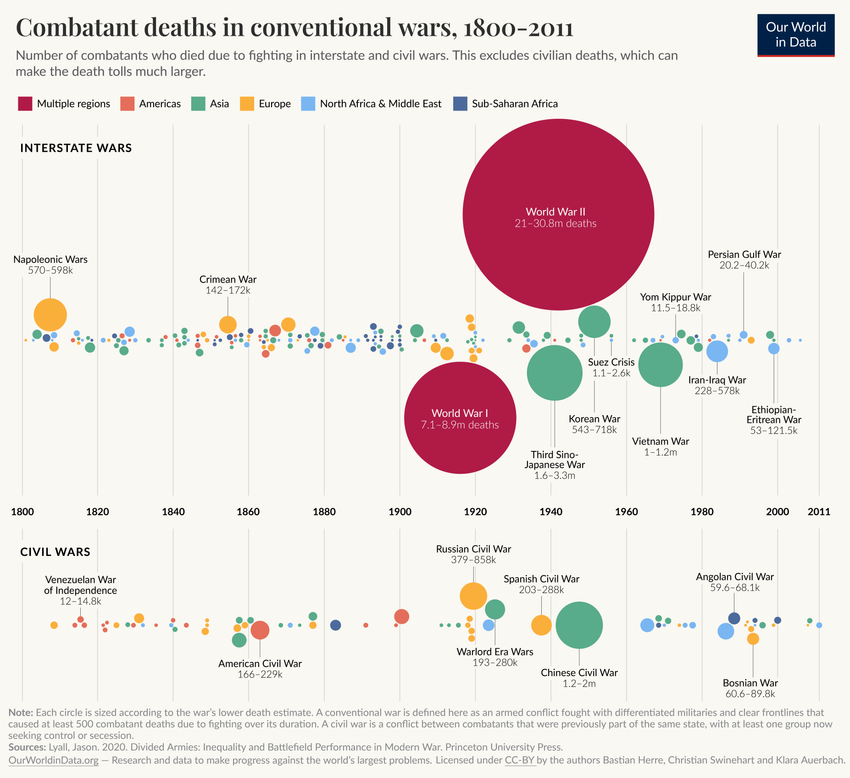

In [ ]:
For comparison from https://www.economist.com/graphic-detail/2018/11/08/which-countries-are-most-likely-to-fight-wars

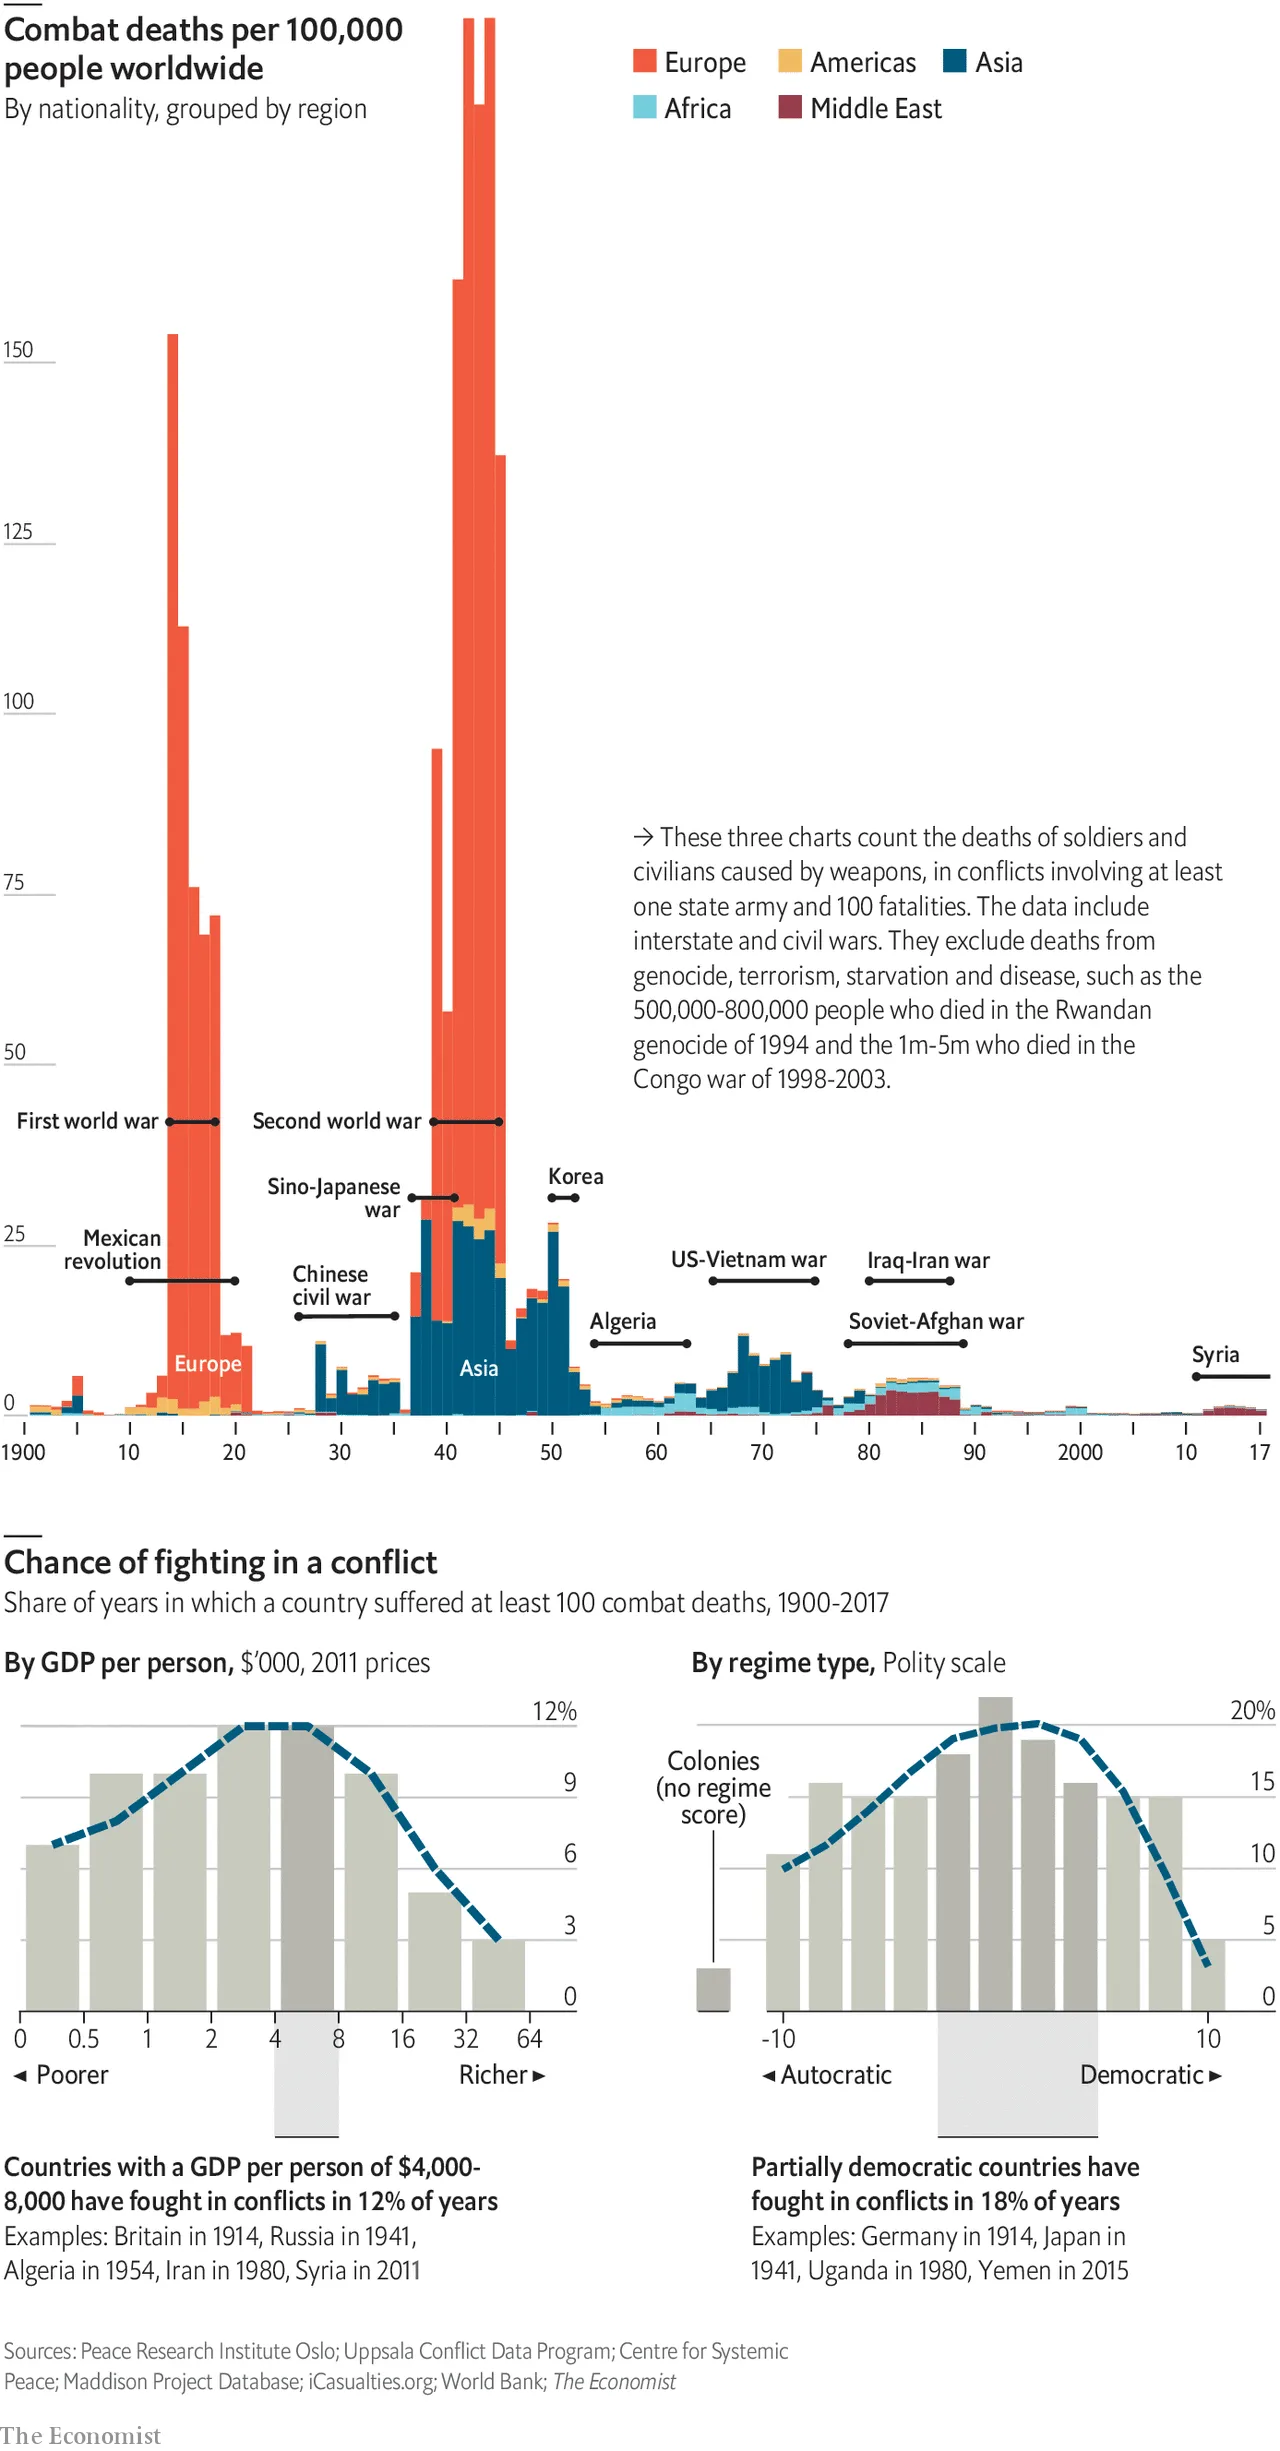